In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2023-10-25 14:35:10.900215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 14:35:10.900264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 14:35:10.900296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 14:35:10.908378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 14:35:12.942414: I tensorflow/compiler/

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import cv2

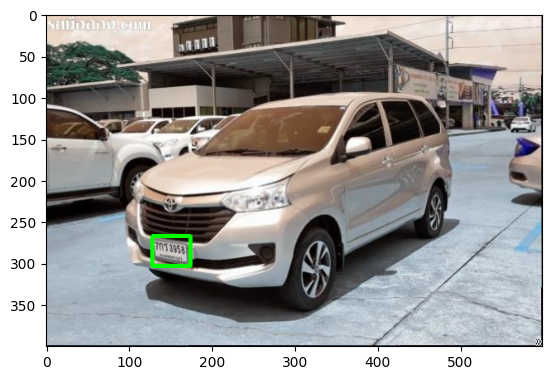

In [3]:
file_path = "dataset/images/b665f2e1-1697729904.767416.jpg"
xmin,xmax,ymin,ymax = 128, 174, 267, 303 # 267, 128, 303, 174
img = cv2.imread(file_path)

cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),3)

plt.imshow(img)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np

IMAGES_PATH = "dataset/images"
rows = open("license_plate.csv").read().strip().split("\n")

data = []
output = []
for row in rows:
    row = row.split(",")
    (filename, xmin, xmax, ymin, ymax) = row
    xmin = int(xmin)
    xmax = int(xmax)
    ymin = int(ymin)
    ymax = int(ymax)
    
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    img_arr = cv2.imread(imagePath)
    h,w,d = img_arr.shape

    # prepprocesing
    load_image = load_img(imagePath, target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [5]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,train_size=0.5,random_state=42)
print('train :', len(x_train), len(y_train))
print('test  :', len(x_test), len(y_test))
print('val   :', len(x_val), len(y_val))

train : 1122 1122
test  : 240 240
val   : 241 241


In [6]:
baseModel = MobileNetV2(weights="imagenet", 
						include_top=False,
						# input_tensor=Input(shape=(224, 224, 3)))
						input_tensor=Input(shape=(224, 224, 3)))

baseModel.trainable=False
# ---------------------
headmodel = baseModel.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=baseModel.input,outputs=headmodel)

2023-10-25 14:35:20.881912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 14:35:20.882095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 14:35:20.882254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
# complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=["accuracy"])
# model.summary()

from tensorflow.keras.callbacks import TensorBoard
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=200,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/200


2023-10-25 14:35:26.706847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-25 14:35:28.262673: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56bcea20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 14:35:28.262728: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-10-25 14:35:28.267862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 14:35:28.361512: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 [==============================] - 11s 54ms/step - loss: 0.0690 - accuracy: 0.6800 - val_loss: 0.0379 - val_accuracy: 0.6792
Epoch 2/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0235 - accuracy: 0.6150 - val_loss: 0.0130 - val_accuracy: 0.4125
Epoch 3/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0078 - accuracy: 0.7344 - val_loss: 0.0040 - val_accuracy: 0.9167
Epoch 4/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0038 - accuracy: 0.8520 - val_loss: 0.0036 - val_accuracy: 0.8625
Epoch 5/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0022 - accuracy: 0.9037 - val_loss: 0.0032 - val_accuracy: 0.9625
Epoch 6/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0015 - accuracy: 0.9563 - val_loss: 0.0026 - val_accuracy: 0.9542
Epoch 7/200
113/113 [==============================] - 5s 42ms/step - loss: 0.0013 - accuracy: 0.9537 - val_loss: 0.0025 - val_accuracy: 0.9417
Epo

1/1 [==============================] - 0s 22ms/step
(446, 210) (500, 240)


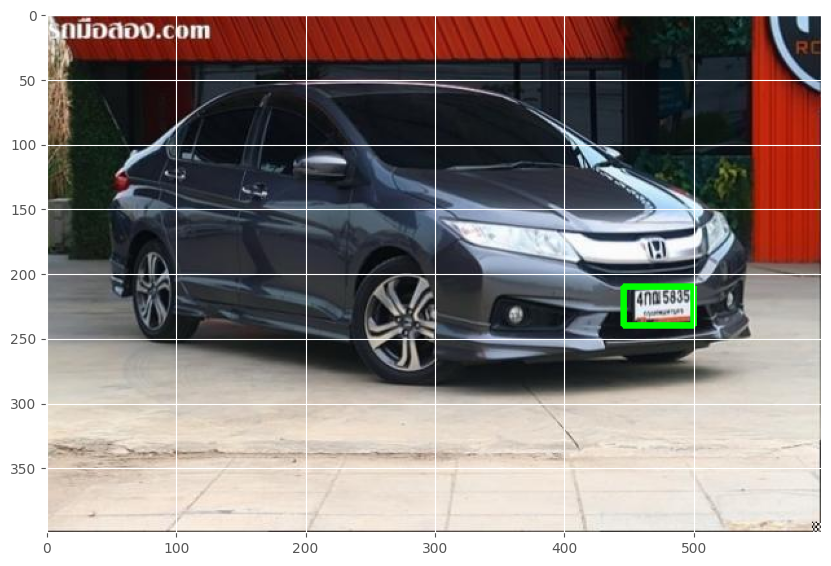

In [13]:

# create pipeline
def object_detection(path):
    # read imagez
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    # data preprocessing
    image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    # make predictions
    coords = model.predict(test_arr)
    # denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    # draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords
    
# ------ get prediction 
path = './dataset/images/00620efc-1697730009.6964722.jpg'
image, cods = object_detection(path)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

# file_path = "dataset/images/b665f2e1-1697729904.767416.jpg"
# xmin,xmax,ymin,ymax = 128, 174, 267, 303 # 267, 128, 303, 174

[INFO] evaluating network...
25/25 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           1       0.97      0.91      0.94        67
           3       0.97      0.99      0.98       174

    accuracy                           0.97       241
   macro avg       0.97      0.95      0.96       241
weighted avg       0.97      0.97      0.97       241

[INFO] saving mask detector model...


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


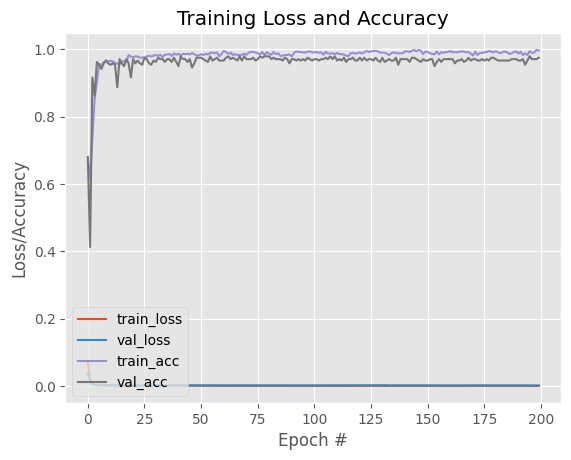

In [9]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(x_val, batch_size=10)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_val.argmax(axis=1), predIdxs))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mobilenet_v2.model", save_format="h5")

# plot the training loss and accuracy
N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output_MobileNetV2")
